# Novozymes Enzyme Stability Prediction - [Kaggle](https://www.kaggle.com/competitions/novozymes-enzyme-stability-prediction/overview)

## Random Forest Approach

In [1]:
# import libraries

import numpy as np # linear algebra stuff
import pandas as pd # data processing stuff
import seaborn as sns # plot fancy stuff
import matplotlib.pyplot as plt # plot stuff
import re # RegEx

from sklearn.impute import SimpleImputer # imputer to replace stuff

In [9]:
# list files in cd

import os
print('Files in currenct directory:\n')
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Files in currenct directory:

.\enzyme-stability-prediction-rand-forest-approch.ipynb
.\Novozymes_Kaggle_Model.ipynb
.\sample_submission.csv
.\test.csv
.\train.csv
.\train_updates_20220929.csv
.\wildtype_structure_prediction_af2.pdb
.\.ipynb_checkpoints\enzyme-stability-prediction-rand-forest-approch-checkpoint.ipynb
.\.ipynb_checkpoints\Novozymes_Kaggle_Model-checkpoint.ipynb


In [3]:
# Load traning set
train = pd.read_csv('train.csv')
print(f'Loaded the training dataset with the size {train.shape} and columns {[train.columns[n] for n in range(len(train.columns))]}')


# Load updates to the training set
train_update = pd.read_csv('train_updates_20220929.csv')
print(f'\nLoaded the updates to the training dataset with the size {train_update.shape} and columns {[train_update.columns[n] for n in range(len(train_update.columns))]}')

# Load test set 
test = pd.read_csv('test.csv')
print(f'\nLoaded the test dataset with the size {test.shape} and columns {[test.columns[n] for n in range(len(test.columns))]}')

Loaded the training dataset with the size (31390, 5) and columns ['seq_id', 'protein_sequence', 'pH', 'data_source', 'tm']

Loaded the updates to the training dataset with the size (2434, 5) and columns ['seq_id', 'protein_sequence', 'pH', 'data_source', 'tm']

Loaded the test dataset with the size (2413, 4) and columns ['seq_id', 'protein_sequence', 'pH', 'data_source']


# Exploratory Data Analysis

In [4]:
train_update.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2434 entries, 0 to 2433
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   seq_id            2434 non-null   int64  
 1   protein_sequence  25 non-null     object 
 2   pH                25 non-null     float64
 3   data_source       0 non-null      float64
 4   tm                25 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 95.2+ KB


In [5]:
train.head()

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31390 entries, 0 to 31389
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   seq_id            31390 non-null  int64  
 1   protein_sequence  31390 non-null  object 
 2   pH                31104 non-null  float64
 3   data_source       28043 non-null  object 
 4   tm                31390 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.2+ MB


In [7]:
train.describe()

,seq_id,pH,tm
count,31390.000000,31104.000000,31390.000000
mean,15694.500000,6.892339,49.147337
std,9061.656811,1.612225,14.010089
min,0.000000,1.990000,-1.000000
25%,7847.250000,7.000000,42.100000
50%,15694.500000,7.000000,48.000000
75%,23541.750000,7.000000,53.800000
max,31389.000000,64.900000,130.000000


In [8]:
train.corr()

C:\Users\10122055\AppData\Local\Temp\ipykernel_18544\2189804198.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.corr()


,seq_id,pH,tm
seq_id,1.000000,-0.040164,0.008750
pH,-0.040164,1.000000,-0.044544
tm,0.008750,-0.044544,1.000000


From above analysis we can find that there is no need of data_source from corelation and statistical description.
So lets remove it.

In [9]:
train = train.drop(['data_source'],axis=1)
train

,seq_id,protein_sequence,pH,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5
...,...,...,...,...
31385,31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,51.8
31386,31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2
31387,31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,64.6
31388,31388,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,50.7


In [10]:
# calculate null value present in training dataset

train.isnull().sum() 

seq_id                0
protein_sequence      0
pH                  286
tm                    0
dtype: int64

In [11]:
train['pH'] = train['pH'].fillna(train['pH'].mean())

C:\Users\10122055\AppData\Local\Temp\ipykernel_18544\1135574138.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(),linewidths=1,cmap=plt.cm.Reds, annot=True);


Text(0.5, 1.0, 'Heatmap for correlation between columns of training data')

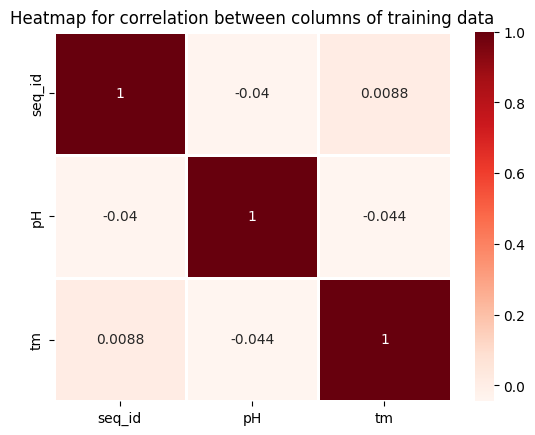

In [12]:
sns.heatmap(train.corr(),linewidths=1,cmap=plt.cm.Reds, annot=True);

plt.title('Heatmap for correlation between columns of training data')

In [13]:
# count of occurrence of A and creating new column
search ="A"
train["A"]=train["protein_sequence"].str.count(search, re.I)

In [14]:
#To make things easier here details of all amino acids are listed in search_amino.
search_amino=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
for amino_acid in search_amino:
     train[amino_acid]=train['protein_sequence'].str.count(amino_acid,re.I)

In [15]:
train.drop(['protein_sequence'],axis=1,inplace=True)
train

,seq_id,pH,tm,A,C,D,E,F,G,H,...,M,N,P,Q,R,S,T,V,W,Y
0,0,7.0,75.7,45,1,13,30,13,38,3,...,8,5,18,6,25,11,14,37,4,3
1,1,7.0,50.5,28,0,10,52,6,18,4,...,2,6,8,22,30,14,12,13,3,3
2,2,7.0,40.5,50,9,27,32,21,65,11,...,6,15,20,25,31,33,30,30,3,16
3,3,7.0,47.2,20,5,19,29,12,16,7,...,2,9,16,9,10,16,19,14,3,4
4,4,7.0,49.5,86,14,78,78,32,84,40,...,31,65,128,54,63,148,120,124,16,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31385,31385,7.0,51.8,33,12,38,31,18,51,15,...,13,24,25,24,42,33,18,42,13,18
31386,31386,7.0,37.2,37,5,21,29,22,27,22,...,14,19,19,16,25,37,26,34,5,14
31387,31387,7.0,64.6,13,1,7,7,7,11,2,...,7,5,6,8,3,10,6,7,4,4
31388,31388,7.0,50.7,47,5,34,36,23,52,11,...,26,25,31,12,25,51,32,48,3,18


In [8]:
my_imputer = SimpleImputer()
data_with_imputed_values = my_imputer.fit_transform(train)

In [ ]:
test.describe()

In [ ]:
search_amino=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
for amino in search_amino:
    test[amino]=test['protein_sequence'].str.count(amino,re.I)

In [ ]:
test.drop(['data_source','protein_sequence'],axis=1,inplace=True)
test.head()

In [ ]:
#Data Visualization of training data

In [ ]:
sns.jointplot(data=train, x="pH", y="tm")

In [ ]:
train['pH'].value_counts()

In [ ]:
train['tm'].value_counts()

In [ ]:
x=train.drop(['tm'],axis=1)
y=train['tm']

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train,x_valid,y_train,y_valid=train_test_split(x,y,test_size=0.20,random_state=42)

In [ ]:
x_train.shape,y_train.shape

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

In [ ]:
rf = RandomForestRegressor()

In [ ]:
from pprint import pprint
#lets find the parameters used by Randomforest models
pprint(rf.get_params())

In [ ]:
from scipy.stats import randint

random_grid={'max_depth':list(np.arange(10, 100, step=10)),
              'n_estimators':np.arange(10, 500, step=50),
              'max_features':randint(1,7),
              'min_samples_leaf':randint(1,4),
              'min_samples_split':np.arange(2, 10, step=2)
         }

In [ ]:
pprint(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters
#create the base model to tune
rf = RandomForestRegressor(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid,
                               n_iter = 50, 
                               scoring = 'neg_mean_absolute_error', 
                               cv = 3, 
                               verbose = 2, 
                               random_state = 42, 
                               n_jobs = -1,
                               return_train_score = True)

# Fit the random search model
rf_random.fit(x_train,y_train)

In [ ]:
y_predict= rf_random.predict(x_valid)
y_predict.shape

In [ ]:
test.shape

In [ ]:
# Density Plot and Histogram of all arrival delays
sns.displot(y_valid, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
# Density Plot and Histogram of all arrival delays
sns.displot(y_predict, hist=True, kde=True, 
             bins=int(180/5), color = 'red', 
             hist_kws={'edgecolor':'green'},
             kde_kws={'linewidth': 4})


In [ ]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_valid, y_predict))
print('Mean Squared Error:', metrics.mean_squared_error(y_valid, y_predict))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_valid, y_predict)))

In [ ]:
from scipy.stats import spearmanr

In [ ]:
from scipy import stats

stats.spearmanr(y_valid, y_predict)

In [ ]:
submission =pd.DataFrame()

In [ ]:
submission['seq_id']=test['seq_id']

In [ ]:
submission['tm'] =rf_random.predict(test)

In [ ]:
submission.to_csv('submission.csv',index=False)
submission

In [ ]:
from IPython.display import FileLink
FileLink(r'submission.csv')